# EA1:

*By Daniel Deutsch and José Lucas Barretto*

In [4]:
import numpy as np
import pandas as pd
import statsmodels.tsa.stattools as sm
import matplotlib.pyplot as plt

In [5]:
# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

## Load the Data

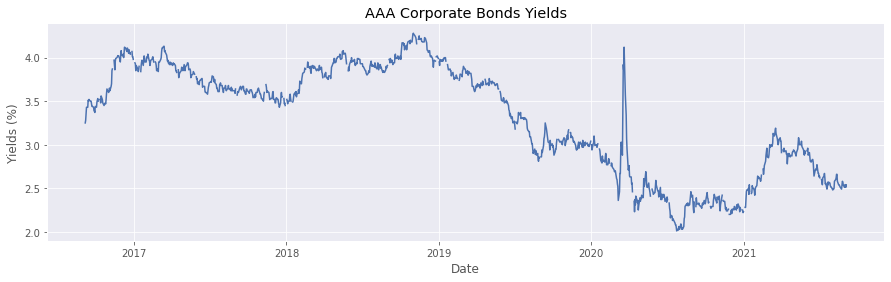

In [9]:
# Loads data and makes small modifications on the df
df_aaa = pd.read_csv("datasets/AAA_corpbonds_yields.csv", na_values='.')
df_aaa['DATE'] = pd.to_datetime(df_aaa['DATE'], format='%Y-%m-%d')
df_aaa.rename(columns={'DATE': 'date', 'DAAA': 'value'}, inplace=True)
df_aaa.dropna(inplace=True)

# Plots the time series
plt.plot(df_aaa['date'], df_aaa['value'])
plt.title("AAA Corporate Bonds Yields")
plt.xlabel("Date")
plt.ylabel("Yields (%)")
plt.show()

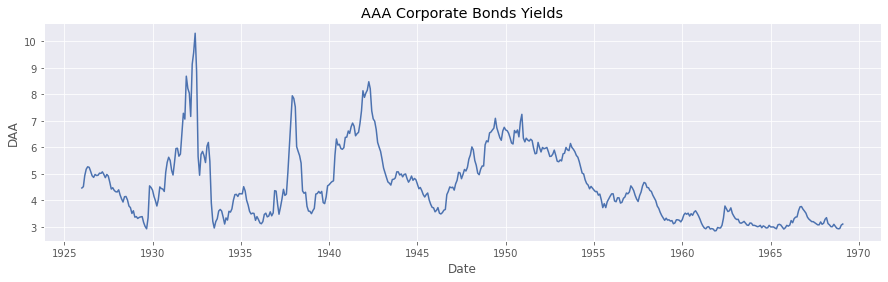

In [8]:
# Loads data and makes small modifications on the df
df_nyse = pd.read_csv("datasets/NYSE_stock_yields.csv", na_values='.')
df_nyse['DATE'] = pd.to_datetime(df_nyse['DATE'], format='%Y-%m-%d')
df_nyse.rename(columns={'DATE': 'date', 'M1346BUSM156NNBR': 'value'}, inplace=True)
df_nyse.dropna(inplace=True)

# Plots the time series
plt.plot(df_nyse['date'], df_nyse['value'])
plt.title("NYSE Stock Yields")
plt.xlabel("Date")
plt.ylabel("Yields (%)")
plt.show()

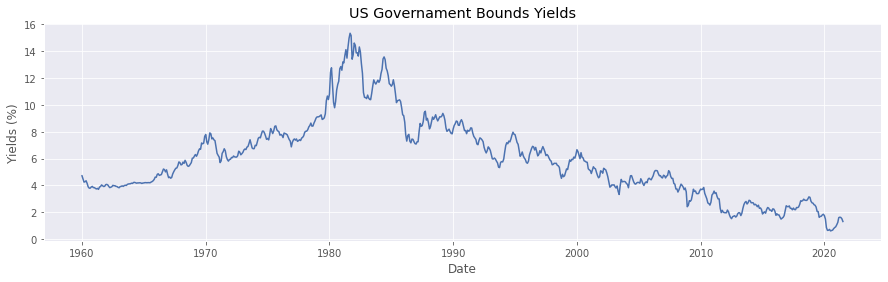

In [10]:
# Loads data and makes small modifications on the df
df_us = pd.read_csv("datasets/US_govbonds_yields.csv", na_values='.')
df_us['DATE'] = pd.to_datetime(df_us['DATE'], format='%Y-%m-%d')
df_us.rename(columns={'DATE': 'date', 'IRLTLT01USM156N': 'value'}, inplace=True)
df_us.dropna(inplace=True)

# Plots the time series
plt.plot(df_us['date'], df_us['value'])
plt.title("US Governament Bounds Yields")
plt.xlabel("Date")
plt.ylabel("Yields (%)")
plt.show()

## Apply Log-Transform

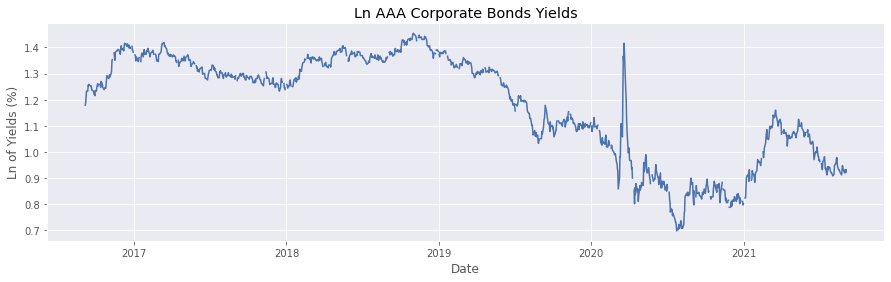

In [11]:
df_aaa['value'] = np.log(df_aaa['value'])

# Plots the time series
plt.plot(df_aaa['date'], df_aaa['value'])
plt.title("Ln AAA Corporate Bonds Yields")
plt.xlabel("Date")
plt.ylabel("Ln of Yields (%)")
plt.show()

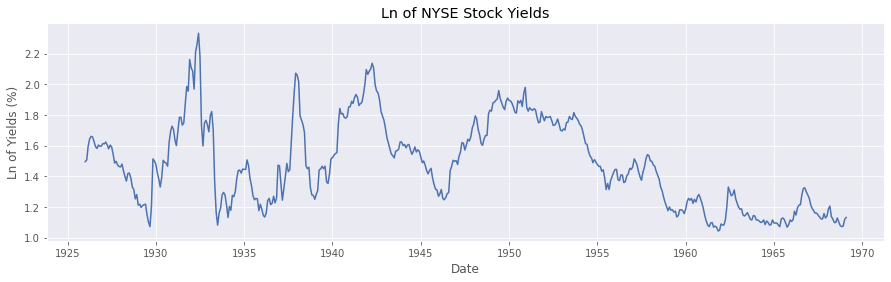

In [12]:
df_nyse['value'] = np.log(df_nyse['value'])

# Plots the time series
plt.plot(df_nyse['date'], df_nyse['value'])
plt.title("Ln of NYSE Stock Yields")
plt.xlabel("Date")
plt.ylabel("Ln of Yields (%)")
plt.show()

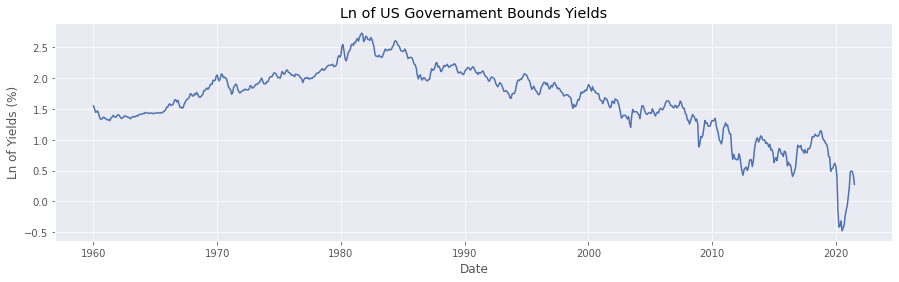

In [13]:
df_us['value'] = np.log(df_us['value'])

# Plots the time series
plt.plot(df_us['date'], df_us['value'])
plt.title("Ln of US Governament Bounds Yields")
plt.xlabel("Date")
plt.ylabel("Ln of Yields (%)")
plt.show()

## Deterministic Trend Analysis

Firstly we shall do the Augmented Dickey-Fuller test to . The test has the following as hypotesis:

<br>

$$
    H_0: \text{there is a unit root.} \\
    H_1: \text{there is no unit root (the time series is stationary).}
$$

<br>

If the pvalue is above a critical size, then we cannot reject that there is a unit root.

In [284]:

adf_res = sm.adfuller(df_aaa['value'], regression='ct', maxlag=1, autolag=None, regresults=True)

In [292]:
print(adf_res[3].resols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.023
Date:                Wed, 08 Sep 2021   Prob (F-statistic):             0.0288
Time:                        16:09:56   Log-Likelihood:                 3346.8
No. Observations:                1249   AIC:                            -6686.
Df Residuals:                    1245   BIC:                            -6665.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0114      0.004     -2.926      0.0

1. Check if x1's t-stat is below critical value -> t-stat for x1 = -2.926 -> we do not reject $H_0: \rho = 0$.

2. Check if coefficient of the trend is statistically significant -> t-stat for x3 = -2.749 -> the coef. of the trend is not significant.

3. Run test again without trend.

## Seasonal Variations Analysis

## Stochastic Trend Analysis

## Stationary ARMA Model